# Preparation

1) Package import 
2) Global variables set

In [2]:
import torch

from data import MakeDataLoader
from models import MNIST_Unet
from train import TrainLoop

In [3]:
# DataLoader variables
DATASET = "mnist"
BATCH_SIZE = 128
SHUFFLE = True

# Train loop variables
NUM_EPOCHS = 10
RESUME = False

# Device variable
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Make dataloader

Sample size:  torch.Size([128, 1, 28, 28])
Labels size:  tensor([6, 0, 9, 4, 5, 6, 1, 7, 8, 1, 8, 5, 6, 1, 2, 6, 4, 6, 7, 1, 6, 9, 0, 7,
        8, 9, 0, 0, 6, 2, 8, 9, 5, 9, 7, 8, 2, 3, 4, 2, 3, 2, 5, 2, 7, 8, 1, 8,
        0, 7, 0, 9, 3, 1, 0, 5, 3, 0, 2, 5, 0, 3, 1, 9, 5, 0, 3, 1, 9, 9, 9, 3,
        7, 2, 4, 2, 8, 7, 9, 8, 8, 9, 7, 9, 9, 8, 4, 3, 1, 3, 0, 7, 2, 5, 2, 8,
        3, 6, 7, 1, 8, 5, 5, 9, 7, 1, 6, 2, 3, 2, 7, 3, 2, 8, 3, 1, 6, 4, 0, 4,
        7, 3, 1, 3, 7, 1, 0, 9])


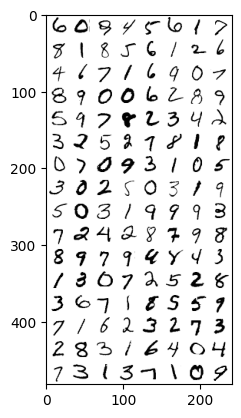

In [3]:
loader_maker = MakeDataLoader(
    ds_name=DATASET,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE
)

loader = loader_maker()

# Build model

In [4]:
model = MNIST_Unet()
print(f"Number of params: {sum(p.numel() for p in model.parameters())}")

Number of params: 1708201


# Train model

Make sure, that there are no checkpoints available to start training. If you train with available checkpoints, they will be rewritten

In [ ]:
train_loop = TrainLoop(
    epochs=NUM_EPOCHS,
    data_loader=loader,
    resume=RESUME,
    model = model,
    ds_name=DATASET,
    device = DEVICE
)

train_loop()

# Unlearn

# Sample

In [4]:
from diffusers import DDPMScheduler
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import torchvision

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')


In [5]:
model = MNIST_Unet()
model.load_state_dict(torch.load("models/checkpoints/mnist.pt"))

<All keys matched successfully>

0it [00:00, ?it/s]

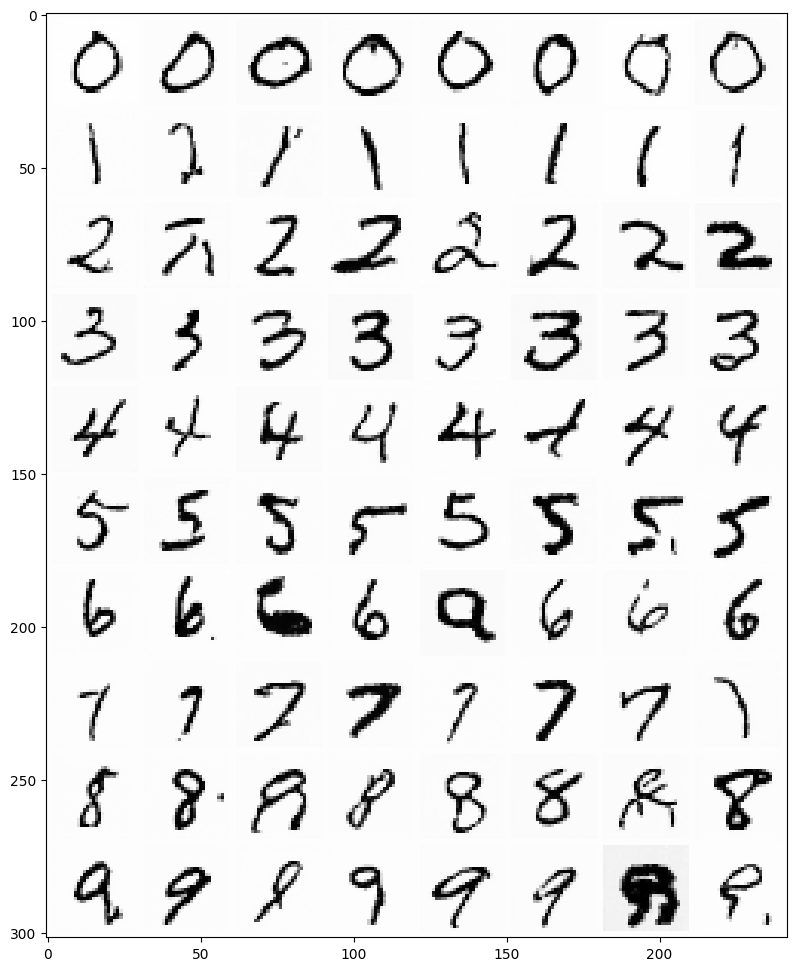

In [6]:

#@markdown Sampling some different digits:

# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28).to(DEVICE)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(DEVICE)
model.to(DEVICE)
# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = model(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')